# Chapter 03

### Setup Environment

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
from numpy.random import beta, binomial

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

%matplotlib inline

## Section 3.1

Setup [Lahman baseball dataset](http://www.seanlahman.com/baseball-archive/statistics/). We downloaded the CSV files locally and will load those -- Python doesn't have an equivalent to R's `Lahman` package.

In [2]:
# read into dataframes
Batting = pd.read_csv('data/Batting.csv', index_col=['playerID', 'yearID'])
Pitching = pd.read_csv('data/Pitching.csv', index_col=['playerID', 'yearID'])
Master = pd.read_csv('data/Master.csv', index_col='playerID')

In [3]:
career = (Batting
          .query("AB > 0")
          .join(Pitching, how='left', rsuffix='_')
          .query("teamID_ != teamID_")  # IS NULL hack for `query` method -> only Batters
          .groupby(level=0)  # group by index -> playerID
          .agg({'H': np.sum, 'AB': np.sum})
          .assign(average = lambda x: x['H'] / x['AB'])
         )

career.head()

,H,AB,average
playerID,,,
aaronha01,3771,12364,0.304998
aaronto01,216,944,0.228814
abadan01,2,21,0.095238
abadijo01,11,49,0.224490
abbated01,772,3044,0.253614


In [4]:
# pull in name
career = (career
          .join(Master)
          .assign(name = lambda x: x['nameFirst'] + ' ' + x['nameLast'])
          [['name', 'H', 'AB', 'average']]  # select only columns we want
         )

career.head()

,name,H,AB,average
playerID,,,,
aaronha01,Hank Aaron,3771,12364,0.304998
aaronto01,Tommie Aaron,216,944,0.228814
abadan01,Andy Abad,2,21,0.095238
abadijo01,John Abadie,11,49,0.224490
abbated01,Ed Abbaticchio,772,3044,0.253614


## Section 3.2
### Step 1: Estimate a prior from all your data

### Figure 3.1

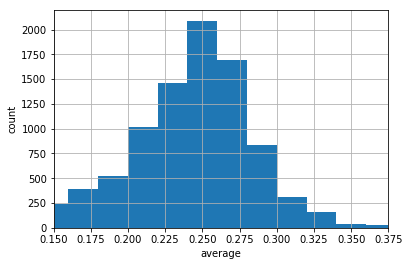

In [5]:
# not sure if in the book this is `career` or `career_filtered` -- code not given
career['average'].hist(bins=50)
plt.xlim(0.15, 0.375)
plt.xlabel('average')
plt.ylabel('count');

In [6]:
career_filtered = career.query("AB > 500")

# maximum likelihood estimation

alpha0, beta0, loc0, scale0 = ss.beta.fit(career_filtered['average'], floc=0, fscale=1)
print('Alpha = {:.2f}, Beta = {:.2f}'.format(alpha0, beta0))

Alpha = 75.88, Beta = 216.69


### Figure 3.2

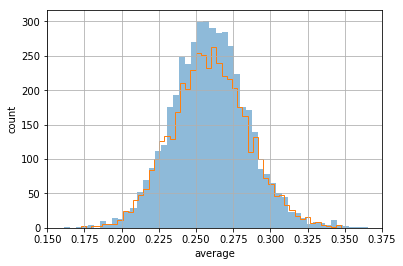

In [7]:
random_fitted = beta(alpha0, beta0, size=len(career_filtered))

# not sure if in the book this is `career` or `career_filtered` -- code not given
# assume it's `career_filtered`, since that's what we're fitting MLE to
career_filtered['average'].hist(bins=50, alpha=.5)
plt.hist(random_fitted, histtype='step', bins=50, alpha=2)
plt.xlim(0.15, 0.375)
plt.xlabel('average')
plt.ylabel('count');

Seems like a pretty good fit to me.

## Section 3.3
### Step 2: Use that distribution as a prior for each individual estimate

In [8]:
eb_estimate_func = lambda x: (x['H'] + alpha0) / (x['AB'] + alpha0 + beta0)

career_eb = career.assign(eb_estimate=eb_estimate_func)
career_eb.head()

,name,H,AB,average,eb_estimate
playerID,,,,,
aaronha01,Hank Aaron,3771,12364,0.304998,0.303943
aaronto01,Tommie Aaron,216,944,0.228814,0.236040
abadan01,Andy Abad,2,21,0.095238,0.248366
abadijo01,John Abadie,11,49,0.224490,0.254356
abbated01,Ed Abbaticchio,772,3044,0.253614,0.254117


## Section 3.4
### Results

**NOTE:** Our numbers will be slightly different.

In [9]:
career_eb.sort_values('eb_estimate', ascending=False).head(10)

,name,H,AB,average,eb_estimate
playerID,,,,,
cobbty01,Ty Cobb,3871,10598,0.365258,0.362413
hornsro01,Rogers Hornsby,2930,8173,0.358497,0.355071
jacksjo01,Shoeless Joe Jackson,1772,4981,0.355752,0.350404
odoulle01,Lefty O'Doul,1126,3192,0.352757,0.344915
delahed01,Ed Delahanty,2596,7505,0.345903,0.342656
speaktr01,Tris Speaker,3321,9624,0.345075,0.342546
willite01,Ted Williams,2461,7145,0.344437,0.341090
hamilbi01,Billy Hamilton,2158,6268,0.344288,0.340501
sislege01,George Sisler,1565,4528,0.345627,0.340391


In [10]:
career_eb.sort_values('eb_estimate', ascending=True).head(10)

,name,H,AB,average,eb_estimate
playerID,,,,,
bergebi01,Bill Bergen,516,3028,0.170410,0.178247
oylerra01,Ray Oyler,221,1265,0.174704,0.190605
humphjo01,John Humphries,52,364,0.142857,0.194770
vukovjo01,John Vukovich,90,559,0.161002,0.194793
bakerge01,George Baker,74,474,0.156118,0.195520
gladmbu01,Buck Gladmon,56,380,0.147368,0.196084
eastehe01,Henry Easterday,203,1129,0.179805,0.196178
armbrch01,Charlie Armbruster,53,355,0.149296,0.199021
bastich01,Charlie Bastian,321,1700,0.188824,0.199180


### Figure 3.3

(0.15, 0.4)

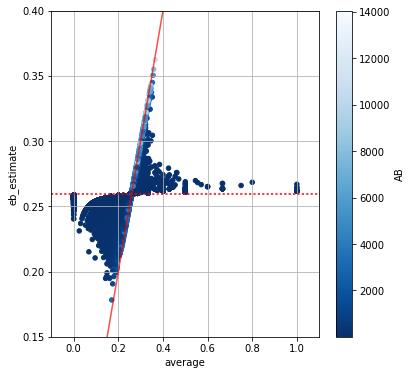

In [11]:
# what we would guess someone's batting average is with no evidence
prior = alpha0 / (alpha0 + beta0)

# use of `sharex` is a hack due to a known bug in pandas:
# https://github.com/pandas-dev/pandas/issues/10611
ax = career_eb.plot.scatter(x='average', y='eb_estimate', c='AB',
                            colormap='Blues_r', figsize=(6,6), grid=True,
                            sharex=False)

plt.axhline(prior, color='r', linestyle=':')

# draw a straight line where x = y
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),
    np.max([ax.get_xlim(), ax.get_ylim()])
]

plt.plot(lims, lims, 'r-', alpha=.7)

# redo axes limits
plt.xlim(-0.1, 1.1)
plt.ylim(0.150, 0.400)

I miss ggplot2.